<a href="https://colab.research.google.com/github/adiknur007/ML/blob/main/%D0%A1%D3%A8%D0%96_16_Nurtaev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recurrent Neural Networks (RNN)

Дәстүрлі нейрондық желілерден айырмашылығы, RNN-нің **жады** бар. Ол ақпаратты тізбек бойынша сақтайды. Бұл оны мәтін, аудио немесе уақыттық қатарлар (time series) сияқты деректермен жұмыс істеуге таптырмас құрал етеді.

**Негізгі формула:**


Жасырын күй (hidden state)  келесі формула бойынша есептеледі:


$$h_t = \phi(W_{hh}h_{t-1} + W_{xh}x_t + b_h)$$


Мұнда:

$h_t$ — ағымдағы уақыттағы жады.

$x_t$ — кіріс дерегі.

$\phi$ — активация функциясы (әдетте $tanh$).




In [2]:
# Қажетті кітапханаларды импорттау
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

# 1. TODO: Деректерді жүктеу үшін қажетті URL-ді анықтаңыз (мысалы, Yahoo Finance-тан алынған Apple акциялары)
# Бұл шынайы деректер жиынтығы
url = 'https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv'

# 2. TODO: pandas арқылы деректерді оқыңыз
df = pd.read_csv(url)

# Деректердің алғашқы жолдарын көру
print(df.head())

         Date    Open    High     Low    Last   Close  Total Trade Quantity  \
0  2018-09-28  234.05  235.95  230.20  233.50  233.75               3069914   
1  2018-09-27  234.55  236.80  231.10  233.80  233.25               5082859   
2  2018-09-26  240.00  240.00  232.50  235.00  234.25               2240909   
3  2018-09-25  233.30  236.75  232.00  236.25  236.10               2349368   
4  2018-09-24  233.55  239.20  230.75  234.00  233.30               3423509   

   Turnover (Lacs)  
0          7162.35  
1         11859.95  
2          5248.60  
3          5503.90  
4          7999.55  


## 3. Деректерді алдын ала өңдеу

In [4]:
# Біз тек "Close" (жабылу бағасы) бағанасын қолданамыз
data = df.iloc[:, 1:2].values

# 3. TODO: MinMaxScaler көмегімен деректерді [0, 1] аралығына нормализациялаңыз
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Жаттықтыру жиынтығының көлемін анықтау (80%)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        # 4. TODO: 'i'-ден 'i+seq_length'-ке дейінгі терезені алыңыз
        _x = data[i:(i+seq_length)]
        # 5. TODO: келесі мәнді нысана (target) ретінде алыңыз
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x), np.array(y)

seq_length = 60
# 6. TODO: Жаттықтыру және тест деректері үшін тізбектер жасаңыз
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# PyTorch тензорларына айналдыру
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()


## 4. RNN Моделін құру

In [7]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        # 7. TODO: Жасырын қабаттың өлшемін анықтаңыз
        self.hidden_size = hidden_size

        # 8. TODO: nn.RNN қабатын инициализациялаңыз
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)

        # 9. TODO: Шығыс қабатын (Linear) анықтаңыз
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 10. TODO: Бастапқы жасырын күйді (h0) нөлдермен толтырыңыз
        h0 = torch.zeros(1, x.size(0), self.hidden_size)

        # 11. TODO: RNN арқылы деректерді өткізіңіз
        out, _ = self.rnn(x,h0)

        # Соңғы уақыт қадамының шығысын алу
        out = self.fc(out[:, -1, :])
        return out

# Модель параметрлері
input_size = 1
hidden_size = 64
output_size = 1

# 12. TODO: Модельді құрыңыз
model = SimpleRNN(input_size, hidden_size, output_size)


## 5. Модельді жаттықтыру

In [8]:
# 13. TODO: Loss функциясын (MSE) таңдаңыз
criterion = nn.MSELoss()

# 14. TODO: Optimizer (Adam) таңдаңыз
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 20
for epoch in range(epochs):
    # 15. TODO: Градиенттерді нөлге теңестіріңіз
    optimizer.zero_grad()

    # 16. TODO: Forward pass жасаңыз
    outputs = model(X_train)


    # 17. TODO: Қателікті есептеңіз
    loss = criterion(outputs, y_train)

    # 18. TODO: Backward pass (кері таралу) жасаңыз
    loss.backward()

    # 19. TODO: Салмақтарды жаңартыңыз
    optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [5/20], Loss: 0.0541
Epoch [10/20], Loss: 0.0282
Epoch [15/20], Loss: 0.0292
Epoch [20/20], Loss: 0.0217


## 6. Болжам жасау және нәтижені визуализациялау

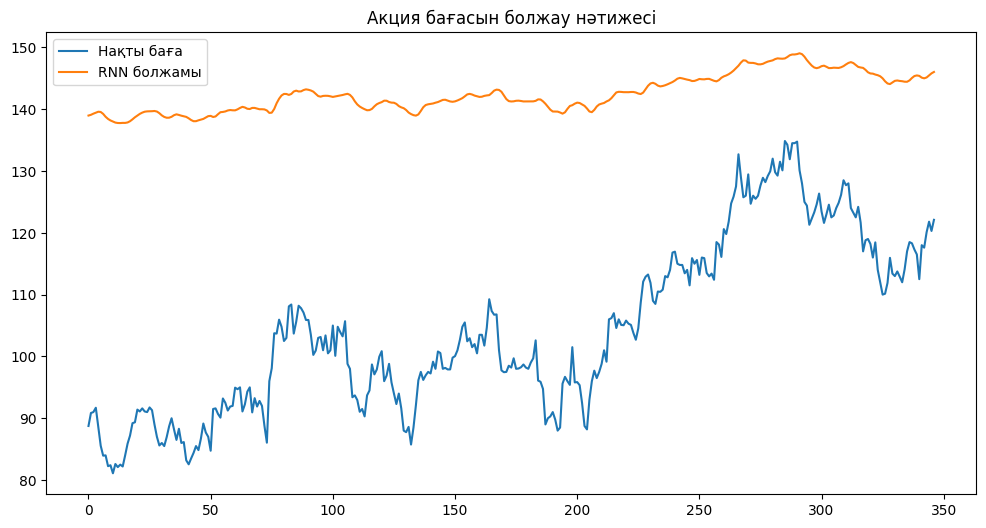

In [9]:
model.eval()
with torch.no_grad():
    # Тест деректерін тензорға айналдыру
    X_test_tensor = torch.from_numpy(X_test).float()

    # 20. TODO: Тест деректеріне болжам жасаңыз
    predictions = model(X_test_tensor)

    # Нормализацияны кері қайтару (Inverse transform)
    predictions = scaler.inverse_transform(predictions.numpy())
    actual = scaler.inverse_transform(y_test)

# Нәтижені сызу
plt.figure(figsize=(12,6))
plt.plot(actual, label='Нақты баға')
plt.plot(predictions, label='RNN болжамы')
plt.title('Акция бағасын болжау нәтижесі')
plt.legend()
plt.show()